# 프로젝트: 고양이 수염 스티커 만들기

## 카메라 스티커앱 만들기 첫걸음

### 코스 내용

- 카메라앱 만들기를 통해 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근 의 기술을 다룹니다.
- 간단한 스티커부터 시작해서 각도 변화가 가능하고 거리 변화에 강건한 스티커 까지 만들 수 있습니다.

### 학습 목표
- 얼굴인식 카메라의 흐름을 이해
- dlib 라이브러리 사용
- 이미지 배열의 인덱싱 예외 처리

# Step 1. 스티커 구하기 or 만들기

스티커를 만들거나 구해야합니다. PPT, 포토샵 등을 이용해서 직접 만드셔도 좋습니다. 보다 간단한 방법은 픽토그램 아이콘을 이용하면 쉽게 만들 수 있습니다.

고양이는 사랑스럽기 때문에 고양이 수염 스티커를 붙여보겠습니다.

## 어떻게 만들까? 사진 준비하기

1. 얼굴이 포함된 사진을 준비하고
2. 사진으로부터 얼굴 영역 face landmark 를 찾아냅니다. (landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾아야합니다.)
3. 찾아진 영역으로 부터 머리에 고양이 스티커를 붙여넣겠습니다.

### 사진을 준비하자

In [556]:
# 파이썬용 opencv 패키지를 설치한 후, 사용할 패키지를 불러옵니다.
!pip install opencv-python
!pip install cmake
!pip install dlib

In [557]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

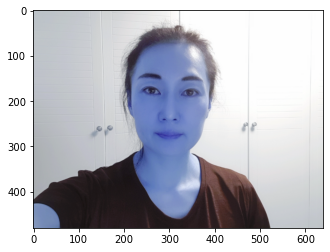

In [558]:
# cv2.imread('img.png', 0) 
# 이미지 읽기의 flag는 3가지가 있습니다.

# 1 --> cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.
# 0 --> cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.
# -1 --> cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.
    
img_bgr = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/beauty_20200903154845.jpg')
img_bgr = cv2.resize(img_bgr, dsize=(640,480)) # 편의를 위해 이미지 크기를 변경합니다. 640x360의 VGA 크기(16:9)로 고정
img_show = img_bgr.copy() # 출력용 이미지 복사
plt.imshow(img_show)

### opencv의 특징

사진이 잘 나온것 같긴 한데 색상이 좀 이상합니다. 얼굴 색에 왜이렇게 푸른빛이 감도는 걸까요? 이것은 opencv의 특징 때문입니다. 오늘 사용하게 될 matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용합니다. 그런데 opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용합니다. 그래서 여러분의 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력된 것입니다. 그래서, opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 아래와 같은 색깔 보정처리를 해주게 됩니다.

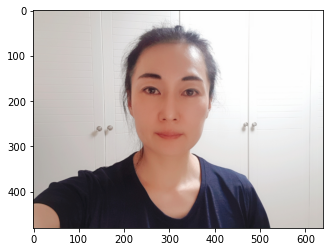

In [559]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# Step 2. 얼굴 검출 & 랜드마크 검출 하기

오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.


## 얼굴 검출 face detection

이번 시간에는 빠르게 만들기 위해 학습 없이 공개되어 있는 패키지를 사용하겠습니다.

dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾습니다. 

1. 이미지에서 그래디언트gradient를 특징feature으로 사용하는 이유는 무엇인가요?

    - 픽셀의 RGB값 자체보다는 인접한 픽셀들 사이의 색상 변화율 자체에 오브젝트의 특징이 더욱 정확히 반영될 때가 많기 때문입니다. 예를 들어, 동일한 오브젝트라도 밝을 때와 어두울 때의 픽셀값의 분포는 완전히 다르지만, 밝기가 변하는 방향(그래디언트)만 고려하면 주변 상황과 무관하게 동일한 표현(representation)을 얻을 수 있습니다.

    - 픽셀을 그래디언트(gradients)로 바꿔야 하는 정말 좋은 이유가 있습니다. 픽셀을 직접 분석하면, 동일한 사람의 정말 어두운 이미지와 정말 밝은 이미지는 전혀 다른 픽셀값을 갖게 될 것입니다. 그러나 밝기가 변하는 방향 만 고려하면 정말 어두운 이미지와 정말 밝은 이미지에 대한 완전히 동일한 표현(representation)을 얻게 됩니다. 이렇게 하면 문제를 훨씬 더 쉽게 해결할 수 있습니다!
    
2. 단일 픽셀의 그래디언트를 사용하지 않고 16x16 의 정사각형을 이용하는 무엇일까요?

    - 그러나 모든 단일 픽셀에 대해 그래디언트를 저장하면 너무 자세합니다. 이렇게 되면 결국 우리는 나무를 보고 숲을 보지 못하게 됩니다. 이미지의 기본 패턴을 알 수 있도록, 높은 수준에서 밝음/어둠의 기본 흐름만을 보는 것이 더 좋습니다.
    - 이를 위해, 이미지를 각각 16x16 픽셀의 작은 정사각형들으로 분해합니다. 각 정사각형에서, 우리는 얼마나 많은 그래디언트가 주요 방향(윗쪽, 우상쪽, 오른쪽, 등)을 얼마나 가리키고 있는지 세어 볼 것입니다 . 그런 다음 이 사각형을 가장 강한 화살표 방향으로 바꿀 것입니다.
    - 결과적으로, 우리는 원본 이미지를 얼굴의 기본 구조가 심플한 방법으로 표시되는 매우 간단한 표현(representation)으로 변환하게 됩니다:


In [560]:
# dlib을 활용해 hog detector를 선언해 봅시다
import dlib
detector_hog = dlib.get_frontal_face_detector()   # detector 선언

- dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었습니다.

- detector_hog의 두 번째 파라미터는 이미지 피라미드의 수입니다. 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능합니다. 이미지 피라미드에 대한 내용은 아래 링크를 참고해 주세요.

In [561]:
# detector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of img pyramid)

dlib detector 는 dlib.rectangles 타입의 객체를 반환합니다.

dlib.rectangles 는 dlib.rectangle 객체의 배열 형태로 이루어져 있습니다.

dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함하고 있습니다. 

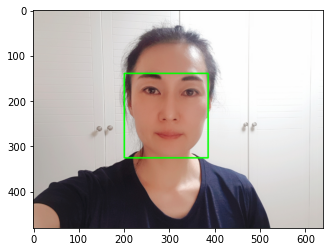

In [562]:
# 찾은 얼굴 화면에 출력하기

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_rgb)
plt.show()

## 얼굴 랜드마크 face landmark

앞서 말씀 드린 것처럼 스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 중요합니다. 이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 합니다. face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용합니다.

### Object keypoint estimation 알고리즘

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 예제에서는 1번 방식을 다룹니다.

### Dlib landmark localization
잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾습니다.

![face_landmark](./face_landmark.png)

Dlib의 제공되는 모델을 사용해보겠습니다. 먼저 공개되어 있는 weight file을 다운로드 받습니다. 위치는 root 디렉토리의 models 디렉토리 입니다. 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용하겠습니다.

- wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
- mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
- cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

# Step 3. 스티커 적용 위치 확인하기

고양이 수염이 적용 될 볼 위치를 landmark를 사용해서 계산해 주세요.

볼은 '턱', '눈', '입', '코' 사이에 있다는 점을 이용해 주세요. 비율로 계산하는 방법 잊지 않으셨죠?

[hint] 2, 36, 48, 30 번 인덱스를 이용

In [563]:
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

In [564]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있습니다. 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었습니다. 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다. 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다.

랜드마크를 영상에 출력해 보겠습니다.

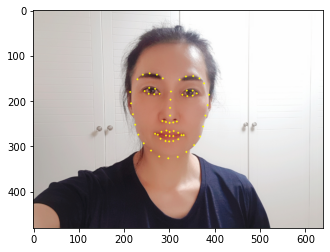

In [565]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# Step 4. 스티커 적용하기

(1) 오늘 배운 np.where 를 사용해서 스티커를 적용해 주세요.

(2) 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다.

[hint] opencv 의 cv2.addWeighted() 를 참고하세요.

## 스티커 적용하기

랜드마크를 기준으로 '눈썹 위 얼굴 중앙' 에 스티커를 씌우면 될 것 같습니다. 구현 방법은 여러 가지가 있습니다. 위 그림처럼 코 중심을 기준으로 높이 x 이상에 그려도 되고 눈썹 위 n 픽셀 위에 스티커를 구현해도 됩니다.

중요한 것은 얼굴 위치, 카메라의 거리에 따라 픽셀 x 가 다르기 때문에 비율로 계산을 해줘야 합니다. 계산할 수치는 두 가지 입니다.

In [566]:
# 좌표 확인해 보기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # nose center index : 30
    x = landmark[33][0]
    y = landmark[33][1] # - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(301, 248)
(x,y) : (301,248)
(w,h) : (186,186)


In [567]:
img_sticker = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/ccat.png')
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(186, 186, 3)


In [568]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.

refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (208,155)


opencv 데이터는 numpy ndarray 형태의 데이터를 사용합니다. ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해줘야 합니다. 따라서 그림에서 보시는 것처럼 원본 이미지의 범위를 벗어난 스티커 부분을 제거해 주어야 합니다.

In [569]:
if refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
            
print (img_sticker.shape)

(186, 186, 3)


In [570]:
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (208,155)


top 의 y 좌표는 원본 이미지의 경계 값으로 수정합니다.

In [571]:
# 원본 이미지에 스티커를 적용합니다. 

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

In [572]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


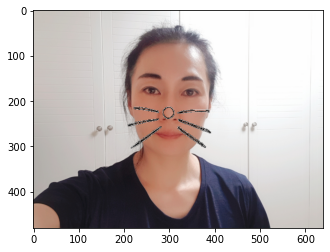

In [573]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# Step 5. 문제점 찾아보기

(1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

* 오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.

    - 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
    - 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    - 실행 속도가 중요할까요?
    - 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

## (1) 옆으로 얼굴을 기울여 보기

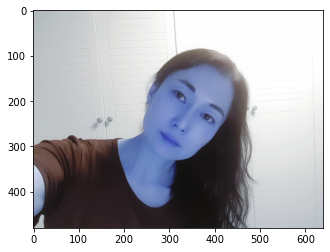

In [575]:
img_bgr = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/beauty_20200909175012.jpg')
img_bgr = cv2.resize(img_bgr, dsize=(640,480)) # 편의를 위해 이미지 크기를 변경합니다. 640x360의 VGA 크기(16:9)로 고정
img_show = img_bgr.copy() # 출력용 이미지 복사
plt.imshow(img_show)

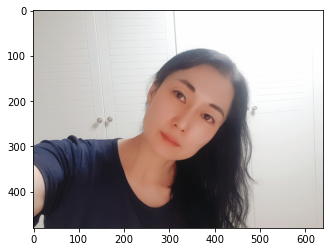

In [576]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [577]:
# dlib을 활용해 hog detector를 선언해 봅시다
import dlib
detector_hog = dlib.get_frontal_face_detector()   # detector 선언

In [578]:
# detector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of img pyramid)

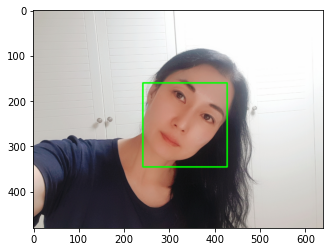

In [579]:
# 찾은 얼굴 화면에 출력하기

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_rgb)
plt.show()

In [580]:
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

In [581]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


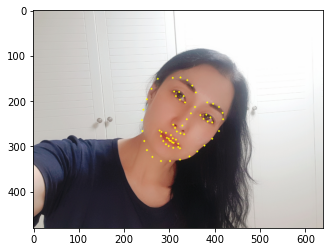

In [582]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [583]:
# 좌표 확인해 보기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[35]) # nose center index : 30
    x = landmark[35][0]
    y = landmark[35][1] # - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(333, 273)
(x,y) : (333,273)
(w,h) : (187,187)


In [584]:
img_sticker = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/ccat.png')
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


In [585]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.

refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (240,180)


In [586]:
if refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
            
print (img_sticker.shape)

(187, 187, 3)


In [587]:
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (240,180)


In [588]:
# 원본 이미지에 스티커를 적용합니다. 

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

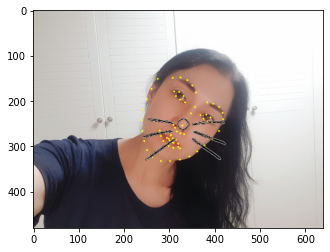

In [589]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.imshow(img_show)
plt.show()

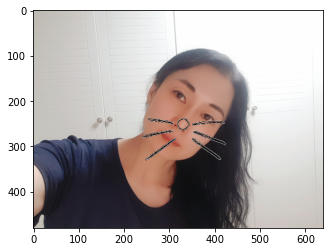

In [590]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## (2) 얼굴 각도를 다르게 해보기

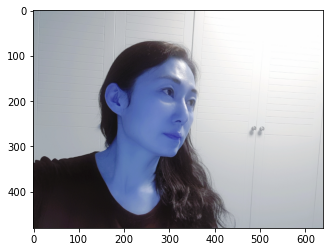

In [591]:
img_bgr = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/beauty_20200909175025.jpg')
img_bgr = cv2.resize(img_bgr, dsize=(640,480)) # 편의를 위해 이미지 크기를 변경합니다. 640x360의 VGA 크기(16:9)로 고정
img_show = img_bgr.copy() # 출력용 이미지 복사
plt.imshow(img_show)

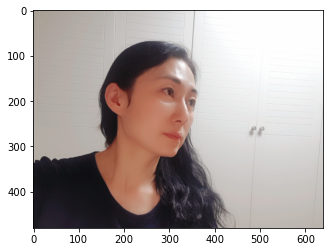

In [592]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [593]:
# dlib을 활용해 hog detector를 선언해 봅시다
import dlib
detector_hog = dlib.get_frontal_face_detector()   # detector 선언

In [594]:
# detector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of img pyramid)

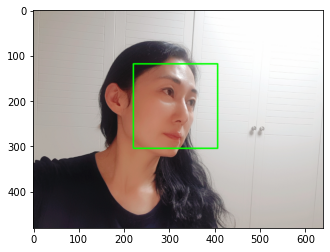

In [595]:
# 찾은 얼굴 화면에 출력하기

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_rgb)
plt.show()

In [596]:
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

In [597]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


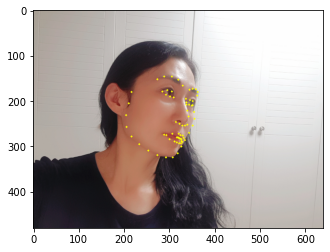

In [598]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [599]:
# 좌표 확인해 보기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[52]) # nose center index : 30
    x = landmark[52][0]
    y = landmark[52][1] # - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(330, 276)
(x,y) : (330,276)
(w,h) : (187,187)


In [600]:
img_sticker = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/ccat.png')
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


In [601]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.

refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (237,183)


In [602]:
if refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
            
print (img_sticker.shape)

(187, 187, 3)


In [603]:
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (237,183)


In [604]:
# 원본 이미지에 스티커를 적용합니다. 

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

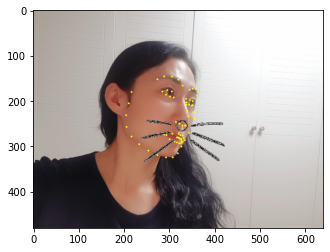

In [606]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.imshow(img_show)
plt.show()

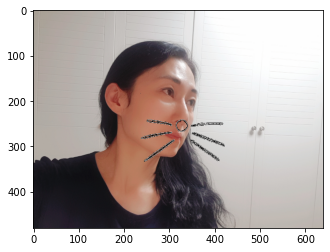

In [607]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## (3) 세로 이미지에 적용해 보기

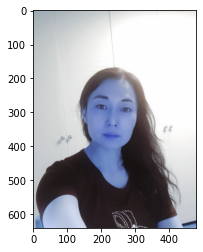

In [608]:
img_bgr = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/beauty_20200909175034.jpg')
img_bgr = cv2.resize(img_bgr, dsize=(480,640)) # 편의를 위해 이미지 크기를 변경합니다. 640x360의 VGA 크기(16:9)로 고정
img_show = img_bgr.copy() # 출력용 이미지 복사
plt.imshow(img_show)

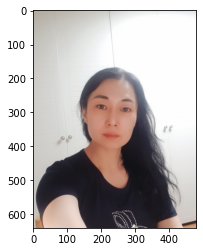

In [609]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [610]:
# dlib을 활용해 hog detector를 선언해 봅시다
import dlib
detector_hog = dlib.get_frontal_face_detector()   # detector 선언

In [611]:
# detector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of img pyramid)

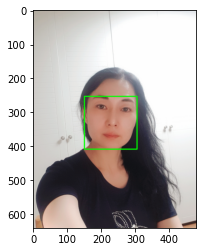

In [612]:
# 찾은 얼굴 화면에 출력하기

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_rgb)
plt.show()

In [613]:
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

In [614]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


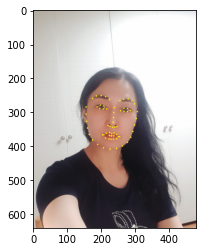

In [615]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [616]:
# 좌표 확인해 보기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # nose center index : 30
    x = landmark[33][0]
    y = landmark[33][1] # - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(232, 344)
(x,y) : (232,344)
(w,h) : (155,155)


In [617]:
img_sticker = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/ccat.png')
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(155, 155, 3)


In [618]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.

refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (155,267)


In [619]:
if refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
            
print (img_sticker.shape)

(155, 155, 3)


In [620]:
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (155,267)


In [621]:
# 원본 이미지에 스티커를 적용합니다. 

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

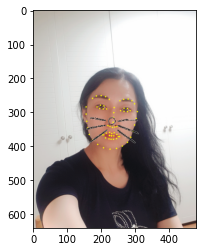

In [622]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.imshow(img_show)
plt.show()

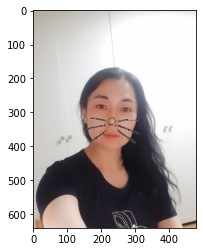

In [623]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## (4) 촬영거리 조절해보기

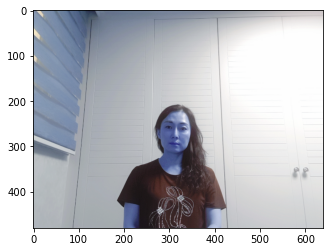

In [626]:
img_bgr = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/beauty_20200909175050.jpg')
img_bgr = cv2.resize(img_bgr, dsize=(640,480)) # 편의를 위해 이미지 크기를 변경합니다. 640x360의 VGA 크기(16:9)로 고정
img_show = img_bgr.copy() # 출력용 이미지 복사
plt.imshow(img_show)

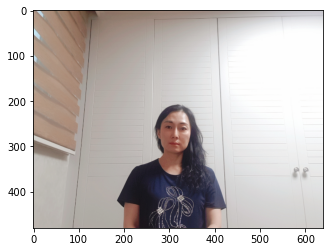

In [627]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [628]:
# dlib을 활용해 hog detector를 선언해 봅시다
import dlib
detector_hog = dlib.get_frontal_face_detector()   # detector 선언

In [629]:
# detector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of img pyramid)

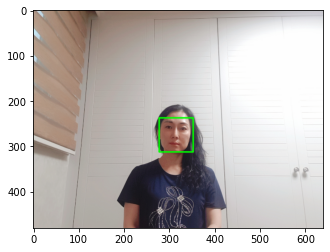

In [630]:
# 찾은 얼굴 화면에 출력하기

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_rgb)
plt.show()

In [631]:
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

In [632]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


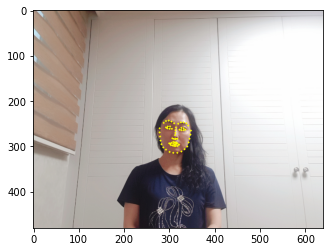

In [633]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [634]:
# 좌표 확인해 보기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # nose center index : 30
    x = landmark[33][0]
    y = landmark[33][1] # - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(313, 284)
(x,y) : (313,284)
(w,h) : (76,76)


In [635]:
img_sticker = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/ccat.png')
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(76, 76, 3)


In [636]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.

refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (275,246)


In [637]:
if refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
            
print (img_sticker.shape)

(76, 76, 3)


In [638]:
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (275,246)


In [639]:
# 원본 이미지에 스티커를 적용합니다. 

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

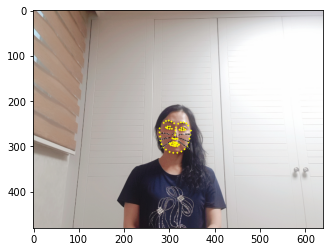

In [640]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.imshow(img_show)
plt.show()

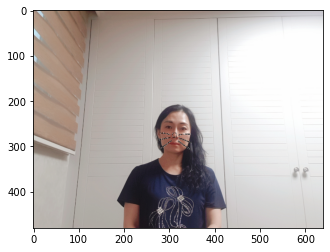

In [641]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 프로젝트 제출 루브릭

### 평가문항	상세기준
1. 자기만의 카메라앱 기능 구현을 완수하였다. : 원본에 스티커 사진이 정상적으로 합성되었다.
2. 스티커 이미지를 정확한 원본 위치에 반영하였다. : 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.
3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다. : 얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.


## 프로젝트 소감

다양한 원본이미지에 적용해 보면서 수염을 붙이는 코 중심의 위치를 조절해 보면서 재미있었다!